In [1]:
# Importing packages

from astropy.io import fits # For handling fits files
from astropy.wcs import WCS # Applying coordinates to images
from astropy.coordinates import SkyCoord
from glob import glob # to search for file paths under similar names
from astropy.coordinates import Angle
from astropy import units as u

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (8,8)

from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

from dataclasses import dataclass

from scipy.optimize import curve_fit

# Importing all data

In [2]:
rootPath = r"/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis"

## M91

In [3]:
# Note each group of files is a list for each band

# Bias
biasFiles_M91 = [glob(rootPath + r"/data_2019/M91/bias/*.fits")]

# Flats
flatsFiles_M91 = [
    glob(rootPath + r"/data_2019/M91/flats/B/*.fits"),
    glob(rootPath + r"/data_2019/M91/flats/V/*.fits"),
    glob(rootPath + r"/data_2019/M91/flats/Halpha_NII/*.fits")
]

# Object
objectFiles_M91 = [
    glob(rootPath + r"/data_2019/M91/object/B/*.fits"),
    glob(rootPath + r"/data_2019/M91/object/V/*.fits"),
    glob(rootPath + r"/data_2019/M91/object/Halpha_NII/*.fits")
]

In [4]:
# Load files using astropy.fits

biasFITS_M91 = [fits.open(el) for el in biasFiles_M91[0]]

flatFITS_M91 = [[fits.open(el) for el in flatsFiles_M91[0]], \
                [fits.open(el) for el in flatsFiles_M91[1]], \
                [fits.open(el) for el in flatsFiles_M91[2]]]

objectFITS_M91 = [[fits.open(el) for el in objectFiles_M91[0]], \
                [fits.open(el) for el in objectFiles_M91[1]], \
                [fits.open(el) for el in objectFiles_M91[2]]]

## NNSer

In [5]:
# Note, only frames of NNSer in the clear band.
import re
# Bias
biasFiles_NNSer = [glob(rootPath + r"/data_2019/NNSer/bias/*.fits")]

# Flats
flatsFiles_NNSer = [glob(rootPath + r"/data_2019/NNSer/flats/clear/*.fits")]

# Object
objectFiles_NNSer = [sorted(glob(rootPath + r"/data_2019/NNSer/object/clear/*.fits"), key=lambda x: tuple(map(int, re.findall(r'\d+', x))))]
print(objectFiles_NNSer)

[['/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/data_2019/NNSer/object/clear/O120308_0175.fits', '/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/data_2019/NNSer/object/clear/O120308_0176.fits', '/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/data_2019/NNSer/object/clear/O120308_0177.fits', '/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/data_2019/NNSer/object/clear/O120308_0178.fits', '/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/data_2019/NNSer/object/clear/O120308_0179.fits', '/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/data_2019/NNSer/object/clear/O120308_0180.fits', '/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/data_2019/NNSer/object/clear/O120308_0181.fits', '/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/data_2019/NNSer/object/clear/O120308_0182.fits', '/home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Ana

In [6]:
biasFITS_NNSer = [fits.open(el) for el in biasFiles_NNSer[0]]

flatFITS_NNSer = [fits.open(el) for el in flatsFiles_NNSer[0]]

objectFITS_NNSer = [fits.open(el) for el in objectFiles_NNSer[0]]

# Data Reduction

## Create Master Bias and Flat files

In [7]:
# Read in the pixel values of each bias into an np array. 
# Find the average value of each pixel across all bias frames. 
# Assign each average pixel to a new file: masterBias.fits


# Takes a list of arrays and returns an array with each element being
# the average element of the list
def createAvgArray(arraysList):
    
    arraySum = np.empty(np.shape(arraysList[0]))
    
    for array in arraysList:
        arraySum += array

    return arraySum / len(arraysList)

# Converts a list of fits files into a list of arrays and passes it to the createAvgArray
# function to get the masterBias
def createMasterBias(biasList):
    
    arraysList = list()
    
    for el in biasList:
        arraysList.append(el[0].data)
    
    avg = createAvgArray(arraysList)

    return avg

# Converts a list of fits files into a list of arrays, subtacting the masterBias,
# and passes it to the createAvgArray function to get the masterFlat
def createMasterFlat(flatsList, masterBias):
    
    arraysList = list()
    
    for el in flatsList:
        arraysList.append(el[0].data - masterBias)
    
    avgArray = createAvgArray(arraysList)
    
    # normalisation, find the value at the centre and divide by it
    xLength, yLength = np.shape(avgArray)
    
    normFac = avgArray[int(xLength/2)][int(yLength/2)]

    return avgArray / normFac

In [8]:
masterBias_M91 = createMasterBias(biasFITS_M91)
masterBias_NNSer = createMasterBias(biasFITS_NNSer)

In [9]:
masterFlats_M91_B = createMasterFlat(flatFITS_M91[0], masterBias_M91)
masterFlats_M91_V = createMasterFlat(flatFITS_M91[1], masterBias_M91)
masterFlats_M91_Ha = createMasterFlat(flatFITS_M91[2], masterBias_M91)

# masterFlats_M91 is a list of 3 master flats, one for each band.
masterFlats_M91 = [masterFlats_M91_B, masterFlats_M91_V, masterFlats_M91_Ha]

masterFlat_NNSer = createMasterFlat(flatFITS_NNSer, masterBias_NNSer)

In [10]:
def writeFITS(array, newPath):
    hdu = fits.PrimaryHDU(array)    
    hdu.writeto(newPath, overwrite=True)
    print(f"FITS image saved to: {newPath}")

In [11]:
writeFITS(masterBias_M91, rootPath + r"/output/masterFiles/masterBias_M91.fits")
writeFITS(masterBias_NNSer, rootPath + r"/output/masterFiles/masterBias_NNSer.fits")

writeFITS(masterFlats_M91_B, rootPath + r"/output/masterFiles/masterFlat_M91_B.fits")
writeFITS(masterFlats_M91_V, rootPath + r"/output/masterFiles/masterFlat_M91_V.fits")
writeFITS(masterFlats_M91_Ha, rootPath + r"/output/masterFiles/masterFlat_M91_Ha.fits")

writeFITS(masterFlat_NNSer, rootPath + r"/output/masterFiles/masterFlat_NNSer.fits")

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterBias_M91.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterBias_NNSer.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterFlat_M91_B.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterFlat_M91_V.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterFlat_M91_Ha.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/masterFiles/masterFlat_NNSer.fits


## Reduce Images

In [12]:
def reduceImage(fitsFile, masterBias, masterFlat, newPath):
    # Reduces the image by subtracting the masterBias file and dividing by the masterFlat.
    # Note that the first 50 pixels are deleted. This is due to the bias = the flat and hence they observe no light
    
    fitsFile = np.delete(fitsFile[0].data, np.arange(0, 50, 1), 1)
    masterBias = np.delete(masterBias[0].data, np.arange(0, 50, 1), 1)
    masterFlat = np.delete(masterFlat[0].data, np.arange(0, 50, 1), 1)
    
    fileArray = fitsFile
    
    np.subtract(fileArray, masterBias)
    fileArray = fileArray / masterFlat
    
    writeFITS(fileArray, newPath)

### M91

In [13]:
# B Band
count=1
for el in objectFITS_M91[0]:
    image = reduceImage(el, fits.open(rootPath + r"/output/masterFiles/masterBias_M91.fits"),\
                        fits.open(rootPath + r"/output/masterFiles/masterFlat_M91_B.fits"), \
                        rootPath+f"/output/M91/B/M91_B_{count:02}.fits")
        
    count+=1

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/B/M91_B_01.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/B/M91_B_02.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/B/M91_B_03.fits


In [14]:
# V Band
count=1
for el in objectFITS_M91[1]:
    image = reduceImage(el, fits.open(rootPath + r"/output/masterFiles/masterBias_M91.fits"),\
                        fits.open(rootPath + r"/output/masterFiles/masterFlat_M91_V.fits"), \
                        rootPath+f"/output/M91/V/M91_V_{count:02}.fits")
        
    count+=1

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/V/M91_V_01.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/V/M91_V_02.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/V/M91_V_03.fits


In [15]:
# Halpha Band
count=1
for el in objectFITS_M91[2]:
    image = reduceImage(el, fits.open(rootPath + r"/output/masterFiles/masterBias_M91.fits"),\
                        fits.open(rootPath + r"/output/masterFiles/masterFlat_M91_Ha.fits"), \
                        rootPath+f"/output/M91/Halpha/M91_Ha_{count:02}.fits")
        
    count+=1

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/Halpha/M91_Ha_01.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/Halpha/M91_Ha_02.fits


### NNSer

In [16]:
# Clear Band
count=1
for el in objectFITS_NNSer:
    image = reduceImage(el, fits.open(rootPath + r"/output/masterFiles/masterBias_NNSer.fits"),\
                        fits.open(rootPath + r"/output/masterFiles/masterFlat_NNSer.fits"), \
                        rootPath+f"/output/NNSer/clear/NNSer_{count:02}.fits")
        
    count+=1

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_01.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_02.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_03.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_04.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_05.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_06.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_07.fits
FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/NNSer/clear/NNSer_08.fits
FITS image saved to: /home/darag

# Combining Bands

In [17]:
# We combine the bands for each set of images.

def combineBands(fitsList, newPath):
    # takes a list of fits files as an input and outputs a single fits file    
    
    arraysList = list()
    
    for el in fitsList:
        arraysList.append(el[0].data)
    
    avgArray = createAvgArray(arraysList)
    
    writeFITS(avgArray, newPath)

In [18]:
M91_combinedList = [fits.open(rootPath + r"/output/M91/B/M91_B_01.fits"), \
                   fits.open(rootPath + r"/output/M91/V/M91_V_01.fits"), \
                   fits.open(rootPath + r"/output/M91/Halpha/M91_Ha_01.fits")]

combineBands(M91_combinedList, rootPath + r"/output/M91/M91_combined_01.fits")

FITS image saved to: /home/daraghhollman/jupyter/UCD_PASS_Labs/Astronomy_Image_Analysis/output/M91/M91_combined_01.fits


# Measurement of Angular Size of M91

In [19]:
def averagePixelCount(array):
    areaCounts=0
    divisor=0
    for line in array:
        for el in line:
            areaCounts += el
            divisor+=1
    return areaCounts / divisor    

def angularSize(fits, bucketSize, tol, vMin, vMax, showPlot=False, color="grey", label="Ellipse"):
    # Function takes fits file as input, plots image with plt.imshow with the angular sizes displayed and returned
    # Returns angular size in arcseconds
    image = fits[0].data
    
    backgroundAvg = averagePixelCount(image[0:250][:,500:750])
    print(backgroundAvg)
    
    # Find Y
    sequence = 0
    angularSizeY = 0
    i=0
    while i < len(image[:,0]):
        j=0
        while j < len(image[0]):
            
            smallAreaAvg = averagePixelCount(image[i:i+bucketSize][:,j:j+bucketSize])
            
            if smallAreaAvg -tol > backgroundAvg:
                sequence += 1
            else:
                if sequence > angularSizeY:angularSizeY = sequence
                sequence = 0
            
            j+=bucketSize
        i+=bucketSize
        
    # Find X
    sequence = 0
    angularSizeX = 0
    i=0
    while i < len(image[0]):
        j=0
        while j < len(image[:,0]):
            
            smallAreaAvg = averagePixelCount(image[:,i:i+bucketSize][j:j+bucketSize])
            
            if smallAreaAvg -tol > backgroundAvg:
                sequence += 1
            else:
                if sequence > angularSizeX:
                    angularSizeX = sequence
                sequence = 0
            
            j+=bucketSize
        i+=bucketSize
    
    # Convert to pixels: * bucketSize
    angularSizeX *= bucketSize
    angularSizeY *= bucketSize
    print(f"Angular Size X: {angularSizeX} pixels, {angularSizeX*0.304} arcseconds")
    print(f"Angular Size Y: {angularSizeY} pixels, {angularSizeY*0.304} arcseconds")
    
    if showPlot:
        plt.imshow(image, vmin=vMin, vmax=vMax, cmap="Greys_r")
        #plt.colorbar()
        
        centre = [1015, 850]
        t = np.linspace(0, 2*np.pi, 100)
        plt.plot( centre[0]+angularSizeX/2*np.cos(t) , centre[1]+angularSizeY/2*np.sin(t), color=color, label=label)
        plt.legend()
        
    return [angularSizeX*0.304, angularSizeY*0.304]

565.4264461850552
Angular Size X: 615 pixels, 186.96 arcseconds
Angular Size Y: 635 pixels, 193.04 arcseconds
565.4264461850552
Angular Size X: 1060 pixels, 322.24 arcseconds
Angular Size Y: 1100 pixels, 334.4 arcseconds
565.4264461850552
Angular Size X: 830 pixels, 252.32 arcseconds
Angular Size Y: 845 pixels, 256.88 arcseconds


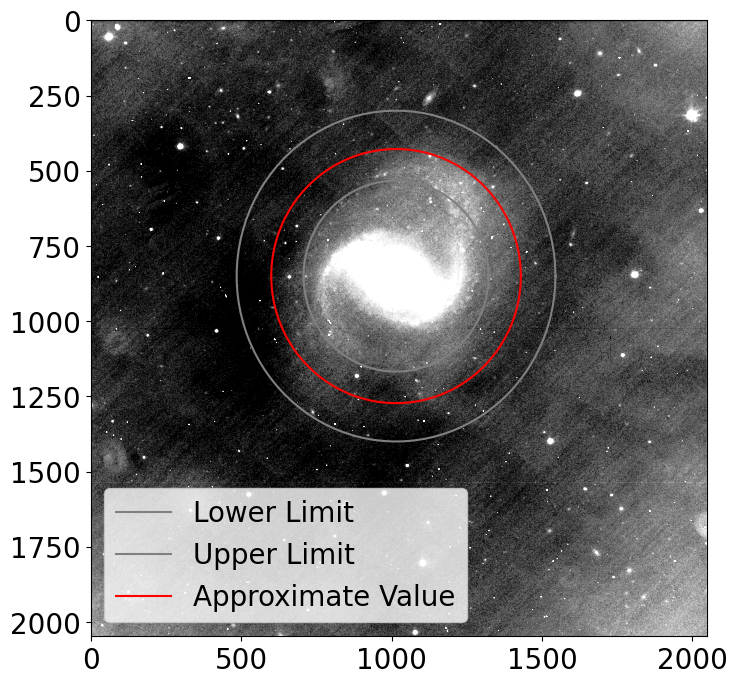

In [20]:
angSizeU1 = angularSize(fits.open(rootPath + r"/output/M91/M91_combined_01.fits"), 5, tol=10, showPlot=True, \
                        label="Lower Limit", vMin=560, vMax=600)
angSizeU2 = angularSize(fits.open(rootPath + r"/output/M91/M91_combined_01.fits"), 5, tol=6, showPlot=True, \
                        label="Upper Limit", vMin=560, vMax=600)
angSize = angularSize(fits.open(rootPath + r"/output/M91/M91_combined_01.fits"), 5, tol=8, showPlot=True, color="red", \
                      label="Approximate Value", vMin=560, vMax=600)

In [21]:
def apparentSize(angSize, dist):
    return angSize / 206265 * dist # by the small angle approximation, 206265 arcseconds in a radian

# Galaxy at distance (15 ± 0.8) Mpc
minor = apparentSize(angSize[0], 15000)
uMinor = (apparentSize(angSizeU2[0], 15000 +800) - apparentSize(angSizeU1[0], 15000-800)) / 2
major = apparentSize(angSize[1], 15000)
uMajor = (apparentSize(angSizeU2[1], 15000+800) - apparentSize(angSizeU1[1], 15000-800)) / 2

print(f"M91 Diameter X: ({minor:0.1f} ± {uMinor:0.1f}) kpc")
print(f"M91 Diameter Y: ({major:0.1f} ± {uMajor:0.1f}) kpc ")

M91 Diameter X: (18.3 ± 5.9) kpc
M91 Diameter Y: (18.7 ± 6.2) kpc 


In [22]:
# Adjust for inclination and position angle

# Adjusting for inclination:
# newDiameter = diameter / cos(inclination) (correcting for inclination)

def InclinationAdjustment(initialDiameter, inclination):
    return initialDiameter / np.cos(inclination)

# NNSer

In [23]:
def wcsToPixel(RA, DEC, wcsPath):
    hdu = fits.open(wcsPath)[0]
    wcs = WCS(hdu.header)
    
    pixelX, pixelY = wcs.wcs_world2pix(RA*15, DEC, 1)
    
    return [[pixelX, pixelY], wcs]

def pixelToWCS(pixelX, pixelY, wcsPath):
    hdu = fits.open(wcsPath)[0]
    wcs = WCS(hdu.header)
    
    RA, DEC = wcs.wcs_pix2world(pixelX, pixelY, 1)
    
    return [[RA/15, DEC], wcs]

## Plot Lightcurve

### Identify ZP stars

In [24]:
starNNSer = wcsToPixel(15.8822, 12.9125, rootPath + r"/output/NNSer/nnserWCS.fits")[0]
print(starNNSer)

[array(1439.7217362), array(1150.9583329)]


In [25]:
def FindStarCoords(RA, DEC, offRA=0, offDEC=0):
    # Takes a reference star at RA and DEC (fmt: '15h52m56.131s') and an offset RA and 
    # DEC (arcseconds). Returns pixel coordinates of the offset star
    coords = SkyCoord(RA, DEC)

    offRA = Angle(offRA, u.arcsecond)
    offDEC = Angle(offDEC, u.arcsecond)
    
    starCoords = wcsToPixel(coords.ra.hour + offRA.hour, coords.dec.degree + offDEC.degree, \
                            rootPath + r"/output/NNSer/nnserWCS.fits")[0]
    
    return starCoords

In [26]:
def plotCirc(x, y, r, label=None):
    t = np.linspace(0, 2*np.pi, 100)
    plt.plot(x + r*np.cos(t), y + r*np.sin(t), label=label)

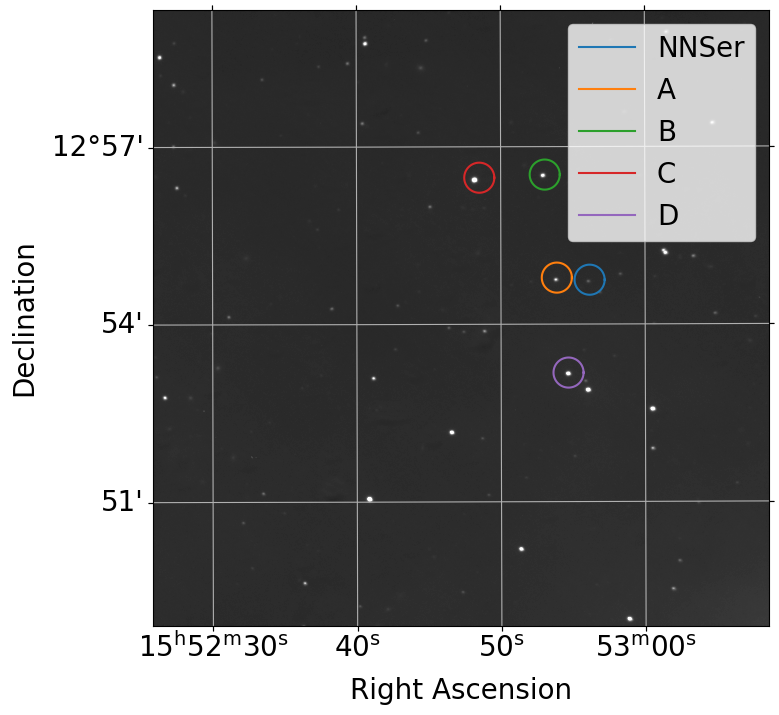

In [27]:
nnserIm17 = fits.open(rootPath + r"/output/NNSer/clear/NNSer_17.fits")[0].data
nnserIm17Head = fits.open(rootPath + r"/output/NNSer/clear/NNSer_17.fits")[0].header

starNNSerCoords = FindStarCoords('15h52m56.131s', '+12d54m44.68s', "0sS", 0)
starACoords = FindStarCoords('15h52m56.131s', '+12d54m44.68s', -34.1, 2.2)
starBCoords = FindStarCoords('15h52m56.131s', '+12d54m44.68s', -46.4, 106.7)
starCCoords = FindStarCoords('15h52m56.131s', '+12d54m44.68s', -114.5, 103.7)
starDCoords = FindStarCoords('15h52m56.131s', '+12d54m44.68s', -22.2, -94.1)

wcs = wcsToPixel(15.8822, 12.9125, rootPath + r"/output/NNSer/nnserWCS.fits")[1]

radius = 50

plt.subplot(projection=wcs)
# NNSer
plotCirc(starNNSerCoords[0], starNNSerCoords[1], radius, label="NNSer")
# StarA
plotCirc(starACoords[0], starACoords[1], radius, label="A")
# StarB
plotCirc(starBCoords[0], starBCoords[1], radius, label="B")
# StarC
plotCirc(starCCoords[0], starCCoords[1], radius, label="C")
# StarD
plotCirc(starDCoords[0], starDCoords[1], radius, label="D")
plt.imshow(nnserIm17, cmap="Greys_r", vmax="10000")
plt.legend()
plt.xlabel("Right Ascension")
plt.ylabel("Declination")
plt.grid()
#plt.scatter(starD.position[0], starD.position[1])

### Find Flux for each Star

In [28]:
@dataclass
class Star:
    name:str
    position:list
    flux:float
    calibratedMagnitude:float
    
    def __init__(self, name, position, flux, calibratedMagnitude):
        self.name = name
        self.position = position
        self.flux = flux
        self.calibratedMagnitude = calibratedMagnitude

def SearchStars(image, fwhm=8., threshold=4, showPlot=False):
    # Median absolute deviation
    medAbsDev = mad_std(image)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*medAbsDev)
    sources = daofind(image)
    
    if (showPlot):
        plt.subplot(projection=wcs)
        plt.imshow(image, vmax=20000)
        plt.scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.5, color="orange")
        plt.grid()

    return sources
    
def FindStar(image, name, approxRA, approxDEC, tolerance = 50, showPlot=False):
    # Inputs approximate RA and DEC, and a tolerance range of pixels.
    # Function will search for every star in the image, and pick out from the resulting table
    # the star which coresponds to the input parameters. (Using DAOStarFinder)
    # Returns A star class with the exact position and flux.
    # Calibrated magnitude will come from the r' band in Table 3 of the lab manual.
    
    # Generate the table of stars found in image
    sources = SearchStars(image, showPlot=showPlot)

    # Find the approximate pixel coordinates from the approximate RA and DEC
    approxPos = FindStarCoords(approxRA, approxDEC)
    
    potentialStars = list()
    for el in sources:
        if (el["xcentroid"] - tolerance < approxPos[0] and el["xcentroid"] + tolerance > approxPos[0] \
           and el["ycentroid"] - tolerance < approxPos[1] and el["ycentroid"] + tolerance > approxPos[1]):
            
            potentialStars.append(el)
    
    if (len(potentialStars) > 1):
        print(f"Error: Cannot return star as there exist too many options within tolerance: {len(potentialStars)}. Try reducing the tolerance range")
        return
    
    if (len(potentialStars) == 0):
        print("There are no stars within tolerance.")
        return
    
    if (len(potentialStars) == 1):
        foundStar = potentialStars[0]
        
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

        # Set up aperture and annulus
        aperture = CircularAperture(positions, r=8.)
        annulusAperture = CircularAnnulus(positions, r_in=12., r_out=16.)

        # Make a list of apertures
        apertures = [aperture, annulusAperture]

        # Run aperture photometry
        photoTable = aperture_photometry(image, apertures)

        backgroundMean = photoTable['aperture_sum_1'] / annulusAperture.area
        backgroundSum = backgroundMean * aperture.area
        finalSum = photoTable['aperture_sum_0'] - backgroundSum
        
        newStar = Star(name, [foundStar["xcentroid"], foundStar["ycentroid"]], finalSum, 0)
        return newStar

In [29]:
# Finding exact star position and flux
starA = FindStar(nnserIm17, "StarA", '15h52m56.131s', '+12d54m44.68s', tolerance=30)
starB = FindStar(nnserIm17, "StarB", '15h52m55s', '+12d56m30s', tolerance=100) # Tolerance higher here as we guess approximately the pos.
starC = FindStar(nnserIm17, "StarC", '15h52m48s', '+12d56m25s', tolerance=30)
starD = FindStar(nnserIm17, "StarD", '15h52m54s', '+12d53m30s', tolerance=50)

# Assigning Star r' band magnitudes
starA.calibratedMagnitude = 15.8
starB.calibratedMagnitude = 15.1
starC.calibratedMagnitude = 13.7
starD.calibratedMagnitude = 13.7

In [30]:
def ZeroPoint(flux, calibratedMagnitude, exposureTime):
    return calibratedMagnitude + 2.5 * np.log10(flux / exposureTime)

zeroPoints = list()
starsList = [starA, starB, starC, starD]

for star in starsList:
    zeroPoints.append(ZeroPoint(star.flux, star.calibratedMagnitude, float(objectFITS_NNSer[17][0].header["EXPTIME"])))
    
avgZeroPoint = np.mean(zeroPoints)
print(avgZeroPoint)

21.405826287873904


In [31]:
def ComputeUncertainties(counts, nStar, nSky, backgroundCounts, readoutNoise):
    
    sigNoiseRat = counts / np.sqrt(counts + nStar*(1 + nStar/nSky) * (backgroundCounts + readoutNoise**2))
    
    return 2.5 * np.log10(1 + sigNoiseRat)

In [32]:
starNNSer = FindStar(nnserIm17, "NNSer", '15h52m56.131s', '+12d54m44.68s', tolerance=30)

def GenerateLightCurve(star, originalFITS, zeroPoint, path, searchTol = 10):
    mags = list()
    exposures = list()
    uncertainties = list()
    readoutNoises = list()
    
    for image in originalFITS:
        exposures.append(float(image[0].header["EXPTIME"]))
        readoutNoises.append(float(image[0].header["RDNOISE"]))
    
    files = glob(path)
    files.sort()
    fitsFiles = [fits.open(file) for file in files]
    
    t=0
    
    for file in fitsFiles:
        
        image = file[0].data
        sources = SearchStars(image)
        # Get the positions of sources in the field
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        
        # Set up aperture and annulus
        aperture = CircularAperture(positions, r=8.)
        annulusAperture = CircularAnnulus(positions, r_in=12., r_out=16.)
        
        # Make a list of apertures
        apertures = [aperture, annulusAperture]
        
        # Run aperture photometry
        photoTable = aperture_photometry(image, apertures)
        
        starInTable = False
        possibilities = list()
        for el in photoTable:
            if (el["xcenter"].value - searchTol < star.position[0] and el["xcenter"].value + searchTol > star.position[0] \
               and el["ycenter"].value - searchTol < star.position[1] and el["ycenter"].value + searchTol > star.position[1]):
                possibilities.append(el["id"])
                
        if (len(possibilities) > 1):
            print("Too many stars within tolerance")
            return
        if (len(possibilities) == 0):
            starInTable = False
            
        if (len(possibilities) == 1):
            starID = possibilities[0]
            starInTable = True
        
        # Limiting Magnitude
        lMag = 0
        lowestSum = -1
        lowestID = 0
        
        backgroundMean = photoTable['aperture_sum_1'] / annulusAperture.area
        backgroundSum = backgroundMean * aperture.area
        finalSum = photoTable['aperture_sum_0'] - backgroundSum
        
        for el in sources:
            if finalSum[el["id"] -1] < lowestSum or lowestSum == -1:
                lowestSum = finalSum[el["id"] -1]
                lowestID = el["id"]
        
        if (starInTable):
            mags.append(-2.5*np.log10(finalSum[starID-1] / exposures[t]) + zeroPoint)
            uncertainties.append(ComputeUncertainties(photoTable['aperture_sum_0'][starID-1], backgroundSum[starID-1], \
                                                      sources[starID-1]["npix"], aperture.area, readoutNoises[t]))
            
        if (not starInTable):
            lMag = (-2.5*np.log10(finalSum[lowestID-1] / exposures[t]) + zeroPoint)
            mags.append(lMag)
            uncertainties.append(ComputeUncertainties(photoTable['aperture_sum_0'][lowestID-1], backgroundSum[starID-1], \
                                                      sources[lowestID-1]["npix"], aperture.area, readoutNoises[t]))
        t+=1
    
    return [mags, uncertainties]
    
curveMags = GenerateLightCurve(starNNSer, objectFITS_NNSer, avgZeroPoint, rootPath + r"/output/NNSer/clear/*.fits")

In [33]:
from datetime import datetime as datetime

def GetTimePositions(fitsList):
    
    timePositions = list()
    
    for image in fitsList:
        totalHours = 0.0
        time = image[0].header["ST"]

        date = datetime.strptime(time, "%H:%M:%S")
        
        totalHours += date.hour
        totalHours += date.minute / 60
        totalHours += date.second / 3600
        
        timePositions.append(totalHours)
    return timePositions

Points with uncertainty of around: 0.667


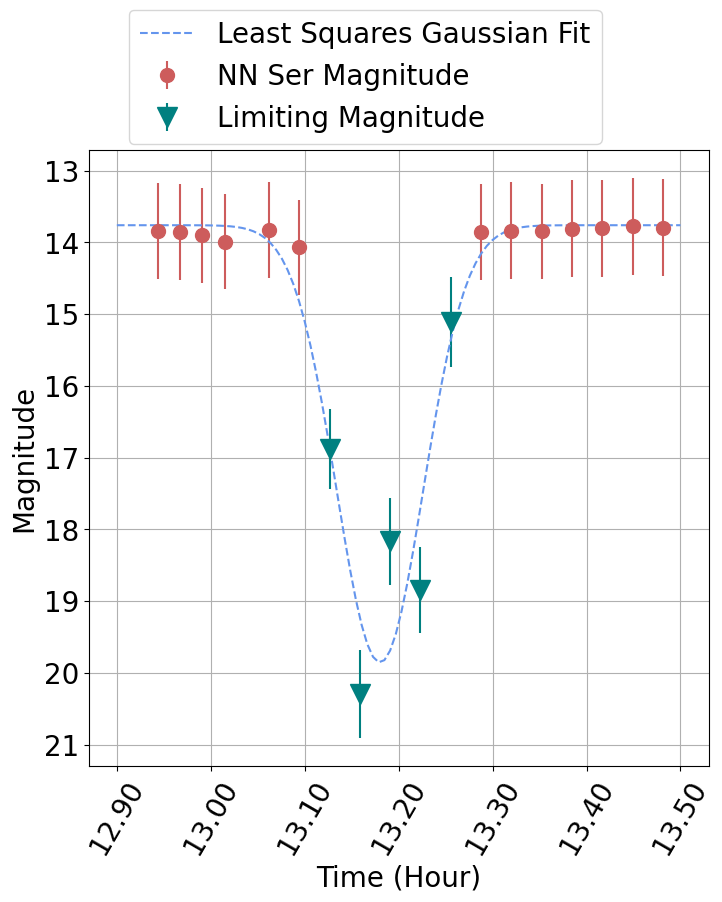

In [50]:
mags = curveMags[0]
magsUncertainty = curveMags[1]
print(f"Points with uncertainty of around: {magsUncertainty[0]:0.3f}")
timePositions = GetTimePositions(objectFITS_NNSer)

def gaussian(x, mu, std, scale, height):
    ans = list()
    for el in x:
        ans.append(scale * np.exp(-(el-mu)**2/(2*std**2)) + height)
    return ans

pars, cov = curve_fit(gaussian, timePositions, mags, [13.2, 0.05, 5, 14])

fig, ax = plt.subplots()

pointColor = "indianred"
arrowColor = "teal"
plt.errorbar(timePositions[0:6], mags[0:6], yerr = magsUncertainty[0:6], fmt="o", \
             color=pointColor, markersize=10, label="NN Ser Magnitude")
plt.errorbar(timePositions[11:], mags[11:], yerr = magsUncertainty[11:], fmt="o", \
             color=pointColor, markersize=10)
plt.errorbar(timePositions[6:11], mags[6:11], yerr = magsUncertainty[6:11], fmt="v", \
             color=arrowColor, markersize=15, label="Limiting Magnitude")

t = np.linspace(12.9, 13.5, 100)
plt.plot(t, gaussian(t, pars[0], pars[1], pars[2], pars[3]), "--", label="Least Squares Gaussian Fit", color="cornflowerblue")

plt.xlabel("Time (Hour)")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(rotation=60)
plt.grid()
plt.legend(bbox_to_anchor =(0.85, 1.25))

In [35]:
# Duration of the eclipse is assumed to be within 2 standard deviations from the mean of the fitted gaussian. 
# i.e. 4 times the standard deviaiton

def duration(std):
    return 4*std

print(f"Duration of the eclipse: {60 * duration(pars[1]):0.3f} minutes")

Duration of the eclipse: 11.052 minutes


In [36]:
#### What parameters can be found, What info would be useful to better constrain the system.